In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
from distgen import Generator
from distgen.physical_constants import unit_registry
from astra.astra_distgen import evaluate_astra_with_distgen
from pmd_beamphysics.plot import marginal_plot
import pickle
import sys
import os

from astra import Astra
font = {'size'   : 20}

mpl.rc('font', **font)



sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/devices/profile_monitor')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/devices/magnet')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/image_processing')
sys.path.append('/global/u1/l/lgupta/cori/GitHub/lcls-tools/lcls_tools/cor_plot')
from lcls_tools import image_processing as imp
from cor_plot_mat_scan import CorPlotMatScan as C


from lcls_tools import image_processing as imp
import ImageProcessing as mip

In [2]:
!pwd

/global/u1/l/lgupta/cori/GitHub/lcls-sc-inj-surrogate/paper


In [3]:
def returnImportantStuff(input_file, bins = 100, nparticles = 1000):
    gen = Generator(input_file)
    gen.input['n_particle'] = nparticles
    #gen.input['r_dist:sigma_xy:value'] = 1/5
    gen.run()
    particles = gen.particles
    px = particles['x']
    py = particles['y']
    sig_x = particles['sigma_x']
    sig_y = particles['sigma_y']
    xhist = np.histogram(px, bins = bins)
    yhist = np.histogram(py, bins = bins)
    H, xedges, yedges = np.histogram2d(px, py, bins=bins)
    return particles, xhist, yhist, H

SG_IN = "files/2019_11_01_005754.yaml"
VCC_IN = "files/2019-11-01T00:57:54_laser_in.yaml"
ASTRA_IN = "/global/homes/l/lgupta/cori/GitHub/lcls-lattice/astra/models/gunb_eic/astra.in"
ARCHIVE_PATH = "/global/u1/l/lgupta/m669/datasets/temp"

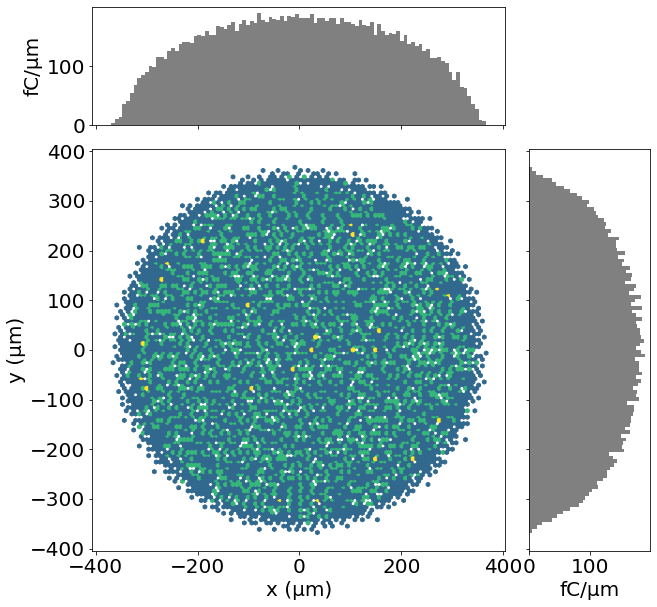

In [4]:
particles, hx, hy, H= returnImportantStuff(SG_IN, bins = 100, nparticles = 10000)
mpl.rcParams['figure.figsize'] = (10,10)
marginal_plot(particles, 'x', 'y', bins = 100)

In [7]:
file_20 = 'files/CorrelationPlot-SOLN_GUNB_212_BCTRL-2019-11-01-003233.mat'
file_4 ='/global/cfs/cdirs/m669/lgupta/MeasuredData/Emittance/CorrelationPlot-SOLN_GUNB_212_BCTRL-2019-11-01-035831.mat'
def getCorrInfo(file):
    data = C(file)
    s = data.samples
    x = data.ctrl_vals
    yarray = []
    yerr = []

    for i in range(0, len(x)):
        yvals = []
        for j in range(0, s):
            yvals.append(((data.beam[i][j][0]['xStat'])[0])[2])
        meany = np.mean(np.array(yvals))
        yarray.append(meany)

        stdy = np.std(yvals)
        yerr.append(stdy)
    yarray = np.array(yarray)
    x = np.array(x)
    return x, yarray, yerr

meas = {}
x, y, ye = getCorrInfo(file_20)
meas["20_x"] = x
meas["20_y"] = y

x, y, ye = getCorrInfo(file_4)
meas["4_x"] = x
meas["4_y"] = y

Done


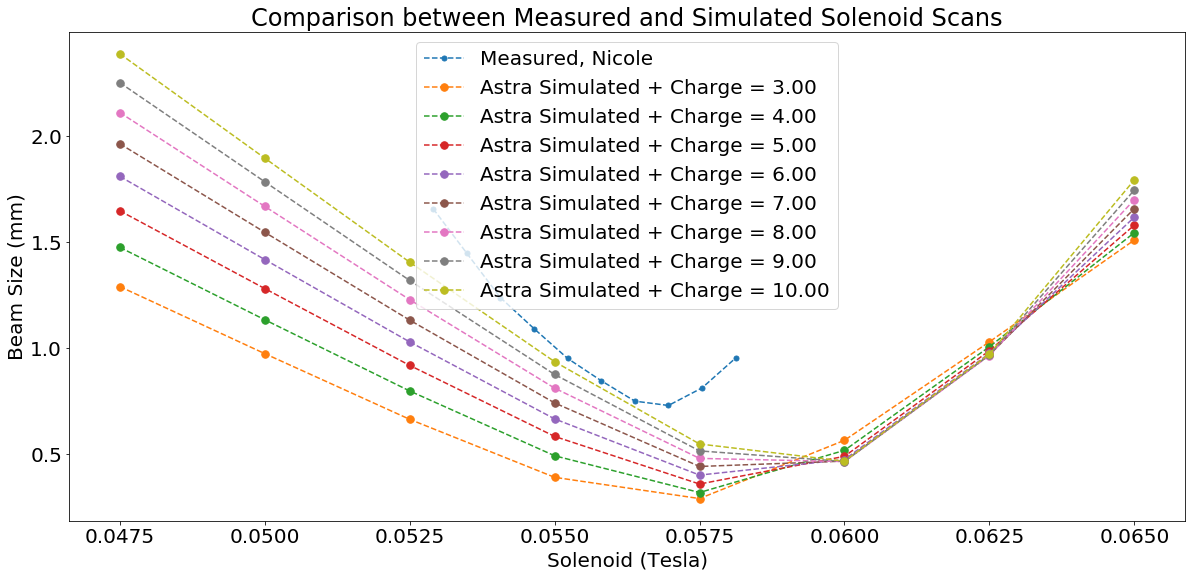

In [8]:
settings ={"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 20.0 , "zphase": 20, "distgen:r_dist:sigma_xy:value": 0.175, 
           "maxe(1)": 18.5}


ALL = {}
plt.figure(figsize = (20,9))
plt.plot(meas["4_x"]/(0.1342*(1/10**(-4))*10**-3), meas["4_y"]*1E-3, '.--', markersize = 10, label = "Measured, Nicole")
charges = [3, 4, 5, 6, 7, 8, 9, 10]
for c in charges:

    all_outputs = {}
    beam_sizes = []
    solenoids = []
    count = 0

    
    for i in np.arange(0.0475, 0.065, 0.0025):
        settings["maxb(2)"] = i
        settings["distgen:total_charge:value"] = c
        A = evaluate_astra_with_distgen(settings, astra_input_file=ASTRA_IN,
                        distgen_input_file=SG_IN, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[count] = A
        beam_sizes.append(A["end_sigma_x"])
        solenoids.append(i)
        count = count + 1
        
    
    ALL[c] = all_outputs
    
    plt.plot(solenoids, np.array(beam_sizes)*1E3, '.--', markersize = 15, label = "Astra Simulated + Charge = {:.2f}".format(c))

    plt.title("Comparison between Measured and Simulated Solenoid Scans")
    plt.xlabel("Solenoid (Tesla)")
    plt.ylabel("Beam Size (mm)")
    

    
TRIALS = "4pC_chargescan"
    
plt.legend()
# #plt.show()
plt.savefig(TRIALS + "_Astra_Scan.png")
with open(TRIALS + 'solenoid_scan.pickle', 'wb') as handle:
    pickle.dump(all_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

Done


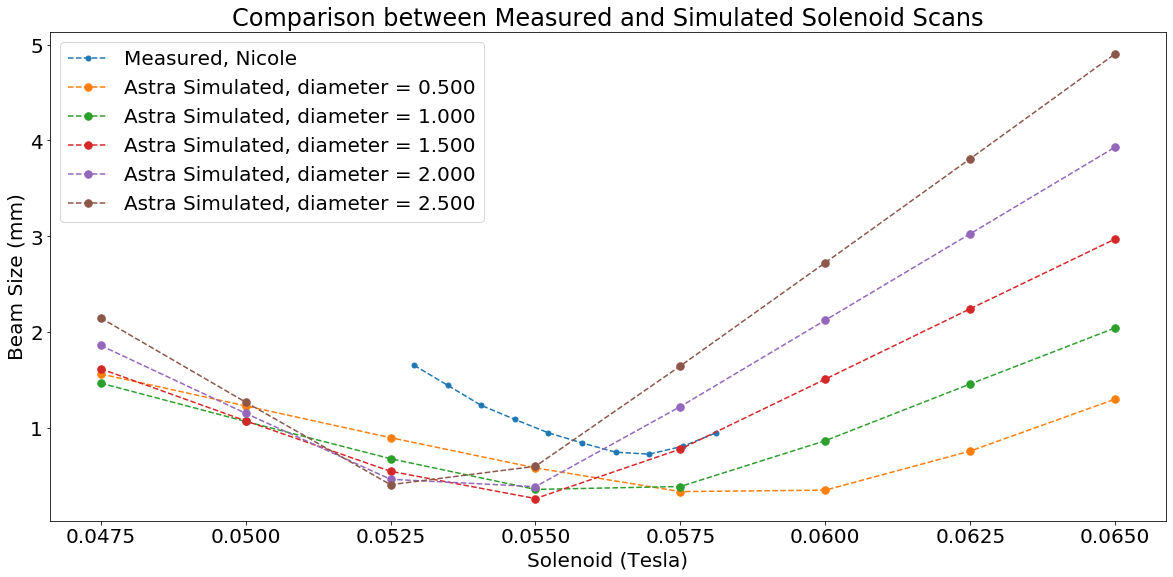

In [9]:
settings ={"distgen:n_particle": 10000, "lspch": True, "zstop": 1.49, "phi(1)": 0 , "maxb(2)": 0.07 , 
             "distgen:total_charge:value": 4 , "zphase": 20, "distgen:r_dist:sigma_xy:value": 0.175, 
           "maxe(1)": 18.5}


ALL = {}
plt.figure(figsize = (20,9))
plt.plot(x/(0.1342*(1/10**(-4))*10**-3), y*1E-3, '.--', markersize = 10, label = "Measured, Nicole")
radii = [i for i in np.arange(0.125, 0.75, 0.125)]


for r in radii:

    all_outputs = {}
    beam_sizes = []
    solenoids = []
    count = 0
    settings["distgen:r_dist:sigma_xy:value"] = r
    for i in np.arange(0.0475, 0.065, 0.0025):
        settings["maxb(2)"] = i
        
        A = evaluate_astra_with_distgen(settings, astra_input_file=ASTRA_IN,
                        distgen_input_file=SG_IN, verbose= False , archive_path = ARCHIVE_PATH)
        all_outputs[count] = A
        beam_sizes.append(A["end_sigma_x"])
        solenoids.append(i)
        count = count + 1
        
    
    ALL[c] = all_outputs
    
    plt.plot(solenoids, np.array(beam_sizes)*1E3, '.--', markersize = 15, label = "Astra Simulated, diameter = {:.3f}".format(r*4))

    plt.title("Comparison between Measured and Simulated Solenoid Scans")
    plt.xlabel("Solenoid (Tesla)")
    plt.ylabel("Beam Size (mm)")
    

    
TRIALS = "4pC_radiiscan"
    
plt.legend()

plt.savefig(TRIALS + "_Astra_Scan.png")
with open(TRIALS + 'solenoid_scan.pickle', 'wb') as handle:
    pickle.dump(all_outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

In [ ]:
### add more points to the radii scan along magnet strength
### do this for the higher charge with 8.5 ps, 330 MTE (), long = gaussian. (20pC case)
### try gradient 18MV and radii (1mm) with space charge

### confirm if the focal point is changing or not for low charge case

### if focal point on 4pC case isn't changing much, then its mostly a charge issue. (double check the 4pC focal point beam size.) but also just add points. 